In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00


Epoch 0, Loss: 998.6179809570312
Epoch 20, Loss: 45.51380157470703
Epoch 40, Loss: 37.92250061035156
Epoch 60, Loss: 32.6817512512207
Epoch 80, Loss: 31.446056365966797
Epoch 100, Loss: 31.27206039428711
Epoch 120, Loss: 31.251632690429688
Epoch 140, Loss: 31.250022888183594
Epoch 160, Loss: 31.250011444091797
Epoch 180, Loss: 31.25000762939453
Predicted PM2.5 concentration for the 5th city: 37.49921417236328


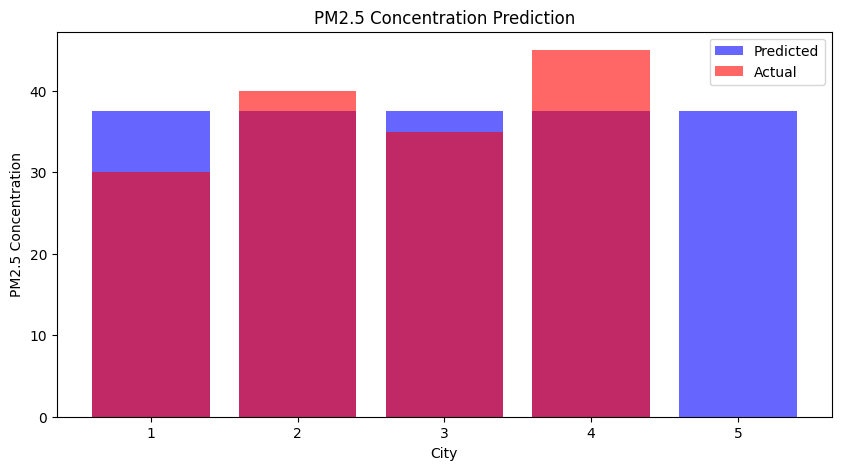

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt

# Define the graph structure (including the 5th city)
edges = torch.tensor([
    [0, 1], [1, 0],
    [1, 2], [2, 1],
    [2, 3], [3, 2],
    [3, 0], [0, 3],
    [0, 2], [2, 0],
    [1, 3], [3, 1],
    [0, 4], [4, 0],
    [1, 4], [4, 1],
    [2, 4], [4, 2],
    [3, 4], [4, 3],
], dtype=torch.long).t().contiguous()

# Features for the 4 known cities and 1 unknown city
features = torch.tensor([
    [10, 20, 0.5],  # City 1
    [12, 18, 0.6],  # City 2
    [14, 17, 0.4],  # City 3
    [11, 19, 0.7],  # City 4
    [13, 16, 0.55], # City 5 (unknown)
], dtype=torch.float)

# PM2.5 concentrations for the 4 known cities
pm25 = torch.tensor([30, 40, 35, 45], dtype=torch.float)

# Add a dummy value for the 5th city
pm25 = torch.cat([pm25, torch.tensor([0], dtype=torch.float)])


data = Data(x=features, edge_index=edges, y=pm25)


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 16, heads=1)
        self.conv2 = GATConv(16, 1, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize the model, optimizer, and loss function
model = GCN()  # Or use GAT() for GAT model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

# Train the model
def train(model, data, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = loss_fn(out[:-1], data.y[:-1])  # Exclude the 5th city during training
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

train(model, data)

# Predict the PM2.5 concentration for the 5th city
model.eval()
with torch.no_grad():
    pred = model(data).squeeze()
    print(f'Predicted PM2.5 concentration for the 5th city: {pred[-1].item()}')

# Plot the results
plt.figure(figsize=(10, 5))
plt.bar(range(1, 6), pred.numpy(), color='blue', alpha=0.6, label='Predicted')
plt.bar(range(1, 5), data.y[:-1].numpy(), color='red', alpha=0.6, label='Actual')
plt.xlabel('City')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.title('PM2.5 Concentration Prediction')
plt.show()


Epoch 20, Loss: 0.0040254960767924786
Epoch 40, Loss: 0.0007656237576156855
Epoch 60, Loss: 0.0002632441173773259
Epoch 80, Loss: 0.00014021017705090344
Epoch 100, Loss: 9.199977648677304e-05
Epoch 120, Loss: 6.4537234720774e-05
Epoch 140, Loss: 4.705809988081455e-05
Epoch 160, Loss: 3.5545330320019275e-05
Epoch 180, Loss: 2.7561309252632782e-05
Epoch 200, Loss: 2.1759833543910645e-05


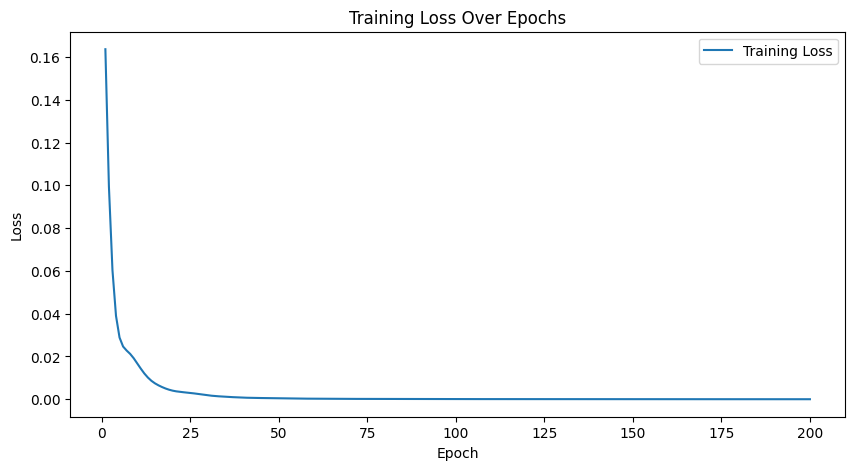

Imputed node features:
tensor([[ 5.5329e-01, -2.9836e-01,  8.2804e-01,  ..., -3.3863e-03,
         -7.1830e-01,  1.1598e+00],
        [ 4.6130e-01,  8.1623e-04, -4.7575e-04,  ..., -1.9078e+00,
          1.6255e-01,  4.6363e-01],
        [ 9.6787e-04,  1.7464e+00,  1.8169e-01,  ..., -3.8207e-03,
          6.0907e-03, -1.0969e-03],
        ...,
        [ 2.1476e-01,  2.3120e+00, -5.3801e-03,  ..., -4.3386e-04,
         -9.9729e-02, -5.1959e-01],
        [ 5.4652e-01,  1.1053e+00,  6.8693e-01,  ..., -1.2565e-01,
          8.2175e-01,  7.9989e-01],
        [ 8.8960e-01,  8.5507e-01, -1.0841e+00,  ...,  2.9184e+00,
         -3.3101e-03,  6.2160e-01]])


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Generate some synthetic data
num_nodes = 100
num_node_features = 16
num_classes = 3

# Randomly generate node features and edges
node_features = torch.randn((num_nodes, num_node_features))
edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))

# Introduce missing values (for example, setting 20% of the features to NaN)
missing_rate = 0.2
mask = torch.rand(num_nodes, num_node_features) > missing_rate
node_features[~mask] = float('nan')

# Imputation mask
imputation_mask = torch.isnan(node_features)

# Initialize missing values with zeros (alternatively, you could use the mean or another strategy)
node_features[imputation_mask] = 0.0

# Initialize the GCN model
hidden_channels = 32
model = GCN(num_node_features, hidden_channels, num_node_features)

# Define a simple mean squared error loss function for imputation
def imputation_loss(pred, target, mask):
    return F.mse_loss(pred[mask], target[mask])

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
model.train()
losses = []
for epoch in range(200):
    optimizer.zero_grad()
    output = model(node_features, edge_index)
    loss = imputation_loss(output, node_features, imputation_mask)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 201), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Impute missing values
model.eval()
with torch.no_grad():
    imputed_node_features = model(node_features, edge_index)
    node_features[imputation_mask] = imputed_node_features[imputation_mask]

print("Imputed node features:")
print(node_features)
